In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import urllib.parse
from urllib.parse import urljoin
import csv

In [2]:
API_KEY = "AIzaSyAVWQOFupr20cHiAeA0cfcjEFTi-VcFiH4AIzaSyAVWQOFupr20cHiAeA0cfcjEFTi-VcFiH4"

In [4]:
df = pd.read_csv("/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 10/get_your_book/data/raw/processed/books_final_version_cleaned.csv", engine="python")
df.head(2)

,title,author,description,url,isbn13,genre,cover_image_uri
0,Faithless,karin slaughter,The victim was buried alive in the Georgia woo...,NaN,9780440242918,"'Audiobook'], 'Crime', 'Fiction', 'Mystery Thr...",https://covers.openlibrary.org/b/isbn/97804402...
1,Congo,michael crichton,Three adventurers trek into the Congo in searc...,NaN,9780060541835,"'Adventure', 'Classics', 'Fantasy'], 'Horror',...",https://covers.openlibrary.org/b/isbn/97800605...


Shape: (3347, 7)
['title', 'author', 'description', 'url', 'isbn13', 'cover_image_uri', 'genre']
TF-IDF shape: (3347, 6488)
k=4: silhouette=0.0285
k=5: silhouette=0.0340
k=6: silhouette=0.0362
k=7: silhouette=0.0387
k=8: silhouette=0.0421
k=9: silhouette=0.0433
k=10: silhouette=0.0336
k=11: silhouette=0.0468
k=12: silhouette=0.0229

✅ Melhor K = 11  (Silhouette = 0.0468)


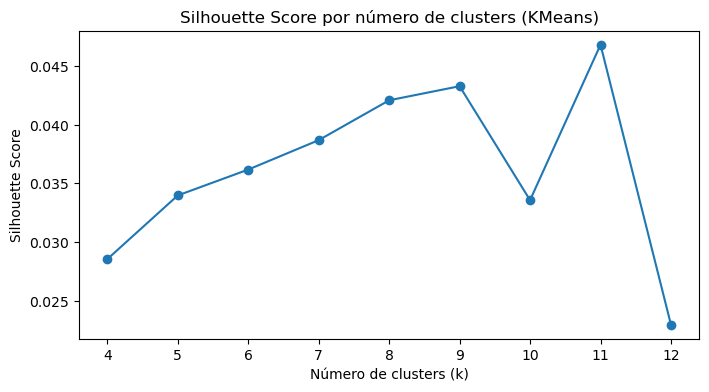


=== Cluster overview ===


,cluster,top_terms
0,0,"new, world, life, book, history, edition, work..."
1,1,"epub digitized, book epub, proofread volunteer..."
2,2,"mystery nonfiction, art nan, occult art, nonfi..."
3,3,"fiction, fantasy, science fiction, science, ad..."
4,4,"mythology, mythology poetry, fantasy, poetry s..."
5,5,"work, important, original, scholars, united, k..."
6,6,"nonfiction, history, philosophy, philosophy na..."
7,7,"literature, fiction, nan free, classics, ficti..."
8,8,"mystery, thriller, fiction, horror, fiction my..."
9,9,"fiction, historical, fiction historical, histo..."



📘 Arquivos salvos em: /home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 10/get_your_book/data/raw/processed/ml_outputs


In [4]:
# =====================================================
# 0️⃣ Imports e setup
# =====================================================
import os, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.sparse import save_npz
import matplotlib.pyplot as plt

# Caminhos
DATA_PATH = Path("/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 10/get_your_book/data/raw/processed")
INPUT_CSV = DATA_PATH / "books_final_version_cleaned.csv"
OUTPUT_DIR = DATA_PATH / "ml_outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# =====================================================
# 1️⃣ Carregar dataset limpo
# =====================================================
df = pd.read_csv(INPUT_CSV)
print("Shape:", df.shape)
print(df.columns.tolist())

# =====================================================
# 2️⃣ Criar campo de texto para NLP
# =====================================================
for col in ["title", "author", "genre", "description"]:
    df[col] = df[col].fillna("").astype(str)

df["text"] = df["title"] + ". " + df["author"] + ". " + df["genre"] + ". " + df["description"]

# =====================================================
# 3️⃣ Vetorização TF-IDF
# =====================================================
vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=3,
    max_features=20000
)
X = vectorizer.fit_transform(df["text"])
X_norm = normalize(X, norm="l2", copy=True)

print("TF-IDF shape:", X.shape)

# =====================================================
# 4️⃣ Teste de K (Silhouette)
# =====================================================
Ks = list(range(4, 13))
scores = {}

for k in Ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels, sample_size=min(2000, X.shape[0]), random_state=42)
    scores[k] = score
    print(f"k={k}: silhouette={score:.4f}")

best_k = max(scores, key=scores.get)
print(f"\n✅ Melhor K = {best_k}  (Silhouette = {scores[best_k]:.4f})")

# Visualizar gráfico Silhouette
plt.figure(figsize=(8, 4))
plt.plot(Ks, [scores[k] for k in Ks], marker="o")
plt.title("Silhouette Score por número de clusters (KMeans)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# =====================================================
# 5️⃣ Treinar modelo final
# =====================================================
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X)
df["cluster"] = labels

# =====================================================
# 6️⃣ Termos representativos
# =====================================================
feature_names = np.array(vectorizer.get_feature_names_out())
centers = kmeans_final.cluster_centers_
top_terms = []

for i in range(best_k):
    top_idx = centers[i].argsort()[-10:][::-1]
    top_terms.append(", ".join(feature_names[top_idx]))

cluster_df = pd.DataFrame({
    "cluster": range(best_k),
    "top_terms": top_terms
})

print("\n=== Cluster overview ===")
display(cluster_df)

# =====================================================
# 7️⃣ Salvar artefatos
# =====================================================
df_out = OUTPUT_DIR / "books_clustered.csv"
df.to_csv(df_out, index=False, encoding="utf-8")
joblib.dump(vectorizer, OUTPUT_DIR / "tfidf_vectorizer.joblib")
joblib.dump(kmeans_final, OUTPUT_DIR / "kmeans_model.joblib")
save_npz(OUTPUT_DIR / "tfidf_matrix_norm.npz", X_norm)

print(f"\n📘 Arquivos salvos em: {OUTPUT_DIR}")


In [5]:
df["genre"].unique()

array(["'Audiobook'], 'Crime', 'Fiction', 'Mystery Thriller', 'Suspense', 'Thriller', Mystery;Thriller;Mystery,Crime;Fiction;Suspense;Thriller,Mystery Thriller;Audiobook;Adult;Mystery,Detective;Contemporary, ['Mystery'",
       "'Adventure', 'Classics', 'Fantasy'], 'Horror', 'Science Fiction', 'Thriller', Fiction;Science Fiction;Thriller;Adventure;Horror;Mystery;Suspense;Cultural,Africa;Novels;Thriller,Mystery Thriller, ['Fiction'",
       "'Contemporary', 'Historical Fiction', 'Literature', 'Novels'], 'Turkish Literature', 'Turkish', ['Fiction', nan",
       "'Audiobook', 'Crime', 'Fiction', 'Mystery Thriller'], 'Mystery', 'Thriller', Fantasy;Fiction;Horror;Science Fiction;Adventure;Westerns;Audiobook;Science Fiction Fantasy;Thriller;Apocalyptic,Post Apocalyptic, ['Horror'",
       "'Entrepreneurship'], 'Finance', 'Nonfiction', 'Personal Development', 'Productivity', 'Self Help', ['Business', nan",
       "'Adult'], 'Crime', 'Fiction', 'Mystery Thriller', 'Suspense', 'Thriller', ['Mys

In [6]:
df["genre"] = (
    df["genre"]
    .astype(str)
    .str.replace(", nan", "", regex=False)
    .str.replace("['", "", regex=False)
    .str.replace("']", "", regex=False)
    .str.replace("']", "", regex=False)
    .str.replace("  ", " ")
    .str.strip()
)


In [7]:
df["genre"].unique()


array(["'Audiobook, 'Crime', 'Fiction', 'Mystery Thriller', 'Suspense', 'Thriller', Mystery;Thriller;Mystery,Crime;Fiction;Suspense;Thriller,Mystery Thriller;Audiobook;Adult;Mystery,Detective;Contemporary, Mystery'",
       "'Adventure', 'Classics', 'Fantasy, 'Horror', 'Science Fiction', 'Thriller', Fiction;Science Fiction;Thriller;Adventure;Horror;Mystery;Suspense;Cultural,Africa;Novels;Thriller,Mystery Thriller, Fiction'",
       "'Contemporary', 'Historical Fiction', 'Literature', 'Novels, 'Turkish Literature', 'Turkish', Fiction'",
       "'Audiobook', 'Crime', 'Fiction', 'Mystery Thriller, 'Mystery', 'Thriller', Fantasy;Fiction;Horror;Science Fiction;Adventure;Westerns;Audiobook;Science Fiction Fantasy;Thriller;Apocalyptic,Post Apocalyptic, Horror'",
       "'Entrepreneurship, 'Finance', 'Nonfiction', 'Personal Development', 'Productivity', 'Self Help', Business'",
       "'Adult, 'Crime', 'Fiction', 'Mystery Thriller', 'Suspense', 'Thriller', Mystery'",
       "'Adventure', 'Fict

In [13]:
import requests

def fetch_book_info(isbn):
    url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"
    response = requests.get(url)

    if response.status_code != 200:
        return None

    data = response.json()

    if "items" not in data:
        return None

    info = data["items"][0]["volumeInfo"]

    return {
        "title": info.get("title"),
        "authors": info.get("authors", []),
        "thumbnail": info.get("imageLinks", {}).get("thumbnail"),
        "description": info.get("description"),
        "categories": info.get("categories", []),
        "publishedDate": info.get("publishedDate"),
        "pageCount": info.get("pageCount"),
    }


In [14]:
def enrich_with_google_books(df):
    df = df.copy()

    new_covers = []
    new_titles = []
    new_authors = []
    new_categories = []
    new_desc = []

    for isbn in df["isbn13"]:
        result = fetch_book_info(isbn)

        if result:
            new_covers.append(result["thumbnail"])
            new_titles.append(result["title"])
            new_authors.append(", ".join(result["authors"]))
            new_categories.append(", ".join(result["categories"]))
            new_desc.append(result["description"])
        else:
            new_covers.append(None)
            new_titles.append(None)
            new_authors.append(None)
            new_categories.append(None)
            new_desc.append(None)

    df["gb_title"] = new_titles
    df["gb_author"] = new_authors
    df["gb_categories"] = new_categories
    df["gb_description"] = new_desc
    df["gb_cover"] = new_covers

    return df
